# ML Pipeline for the UNITI dataset

## Purpose of this notebook
- [x] Prepare dataframe for ML
- [x] Create baseline models
    - [x] User-based
        - [x] last known assessment *of this user*
        - [x] all known assessments *of this user*
    - [x] Assessment-based
        - [x] last known assessment
        - [x] all assessments
- [ ] Perform different split approaches to get different model solutions
    - [x] Answer-Cut
    - [x] Time-Cut
    - [ ] User-wise 
    - [ ] Average-user
    - [ ] Group-wise
- [ ] Evalulate all approaches in one table in terms of performance and robustness

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

# to import own modules, a workaround - assuming the curent working directory is the folder (your/local/path/UsAs/src/d01_analysis
import sys
sys.path.insert(0, "../..")

from src.d00_utils import helpers

In [2]:
# suppress annoying warnings
pd.options.mode.chained_assignment = None

In [3]:
# read in df
df = pd.read_csv('../../data/d02_processed/uniti/uniti.csv', index_col='answer_id')

## Prepare dataframe for ML

Define test data to evaluate all approaches on the same testset.

20 % of the users shall be taken for test, 80 % for trying out different approaches.

In [9]:
# define list of users
users_list = df.user_id.unique()
# 20 % into train users
test_users = pd.Series(users_list).sample(frac=0.2, random_state=1994).to_list()
# 80 % into test users
train_users = [x for x in users_list if x not in set(test_users)]
# unit test 1
assert set(train_users + test_users) == set(users_list)
# unit test 2
assert test_users[:20] == [18153,40272,40135,2355,2325,34144,6180,6724,2110,36262,40402,40273,40311,2118,2317,6692,42321,42686,42678,36478]

# get train and test dataframe
# use train to check approaches, use test to validate approaches
df_train = df[df['user_id'].isin(train_users)]
df_test = df[df['user_id'].isin(test_users)]

In [10]:
# define features and target
features = ['loudness', 'cumberness', 'jawbone', 'neck', 'tin_day', 'tin_cumber', 'tin_max', 'movement', 'stress', 'emotion']
target = ['cumberness_t1']

# get train and test subsets for X and y
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

# make cumberness a classification instead of regression for the target, not for the feature
bins = [-0.01, 20, 40, 60, 80, 100]
y_train = pd.cut(y_train.cumberness_t1, bins=bins)
y_test = pd.cut(y_test.cumberness_t1, bins=bins)

# LabelEncoder
LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
# get class mapping as dict
mapping = dict(zip(range(len(LE.classes_)), LE.classes_))

## Create a baseline model

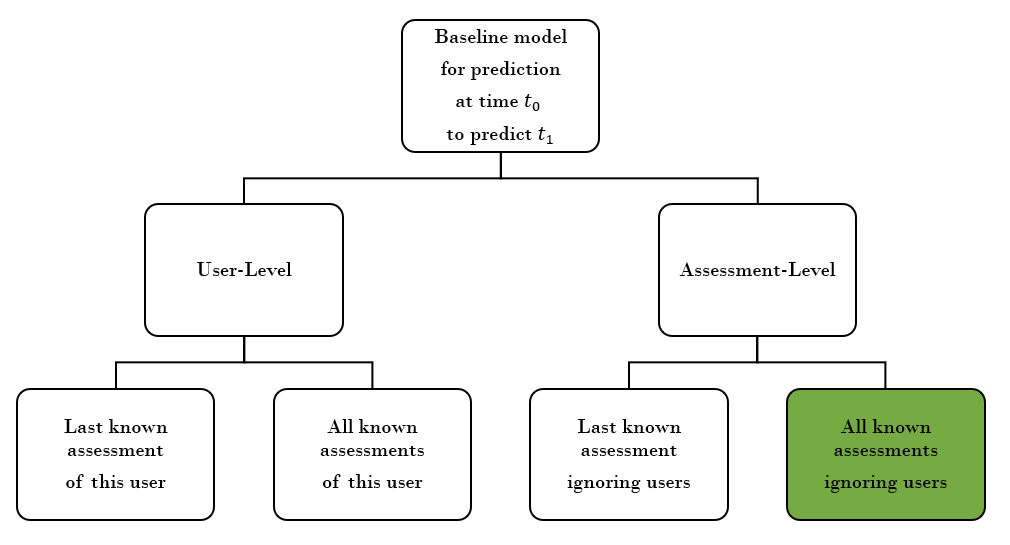

In [15]:
# instantiate model
model = helpers.baseline_model()

# define constants
target_name='cumberness'
approach='all'

# train model in cross validation
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1994)
scores_a = []
scores_u = []
for _, val_indices in cv.split(df_train):
    
    # divide all train data into folds
    df_train_val_fold = df_train.iloc[val_indices, :]
    
    # get baseline prediction
    y_pred_a = model.get_baseline_assessment_prediction(data=df_train_val_fold, target_name=target_name, approach=approach).values
    y_pred_u = model.get_baseline_user_prediction(data=df_train_val_fold, target_name=target_name, approach=approach).values
    y_true = df_train_val_fold[target]
    
    # map into classes
    y_pred_a = pd.cut(pd.Series(y_pred_a), bins=bins)
    y_pred_u = pd.cut(pd.Series(y_pred_u), bins=bins)
    y_true = pd.cut(y_true.cumberness_t1, bins=bins)
    
    # encode to labels
    y_pred_a = LE.transform(y_pred_a)
    y_pred_u = LE.transform(y_pred_u)
    y_true = LE.transform(y_true)
    
    # calculate score
    f1_score_test_a = f1_score(y_true, y_pred_a, average='weighted')
    f1_score_test_u = f1_score(y_true, y_pred_u, average='weighted')
    scores_a.append(f1_score_test_a)
    scores_u.append(f1_score_test_u)
    
# validate model
print('Performance within TRAIN')
print('Assessment approach')
print('f1_weighted mean \t', np.array(scores_a).mean())
print('standarddeviation \t', np.array(scores_a).std())
print('#################################################')
print('User approach')
print('f1_weighted mean \t', np.array(scores_u).mean())
print('standarddeviation \t', np.array(scores_u).std())
# evaluate on test set

# assessment------------------------------------------------------------------------------
y_pred_a = model.get_baseline_assessment_prediction(data=df_test, target_name=target_name, approach=approach).values
# map into classes
y_pred_a = pd.cut(pd.Series(y_pred_a), bins=bins)
# encode to labels
y_pred_a = LE.transform(y_pred_a)

f1_score_test_a = f1_score(y_test, y_pred_a, average='weighted')
final_score_a = f1_score_test_a - 0.5 * np.array(scores_a).std()

print('Performance within TEST')
print('Assessment Final Score:\t', final_score_a)



# visualize confusion matrix
# assessment
# cf_matrix = confusion_matrix(y_test, y_pred_a)
# cm_array_df = pd.DataFrame(cf_matrix, index=list(mapping.values()), columns=list(mapping.values()))
# sns.heatmap(cm_array_df, annot=True, cmap='Blues', fmt='')
# plt.title(f'Final score assessment approach {round(final_score_a, 3)}')
# plt.show()

# user------------------------------------------------------------------------------------

y_pred_u = model.get_baseline_user_prediction(data=df_test, target_name=target_name, approach=approach).values
# map into classes
y_pred_u = pd.cut(pd.Series(y_pred_u), bins=bins)
# encode to labels
y_pred_u = LE.transform(y_pred_u)
f1_score_test_u = f1_score(y_test, y_pred_u, average='weighted')
final_score_u = f1_score_test_u - 0.5 * np.array(scores_u).std()

print('Final score user approach:\t', final_score_u)

# cf_matrix = confusion_matrix(y_test, y_pred_u)
# cm_array_df = pd.DataFrame(cf_matrix, index=list(mapping.values()), columns=list(mapping.values()))
# sns.heatmap(cm_array_df, annot=True, cmap='Blues', fmt='')
# plt.title(f'Final score user approach {round(final_score_u, 3)}')
# plt.show()

Performance within TRAIN
Assessment approach
f1_weighted mean 	 0.09985368247745277
standarddeviation 	 0.007126868119297566
#################################################
User approach
f1_weighted mean 	 0.5110180894208434
standarddeviation 	 0.0012315644301999775
Performance within TEST
Assessment Final Score:	 0.14863211871270182
Final score user approach:	 0.5060010222148694


### Take last assessment

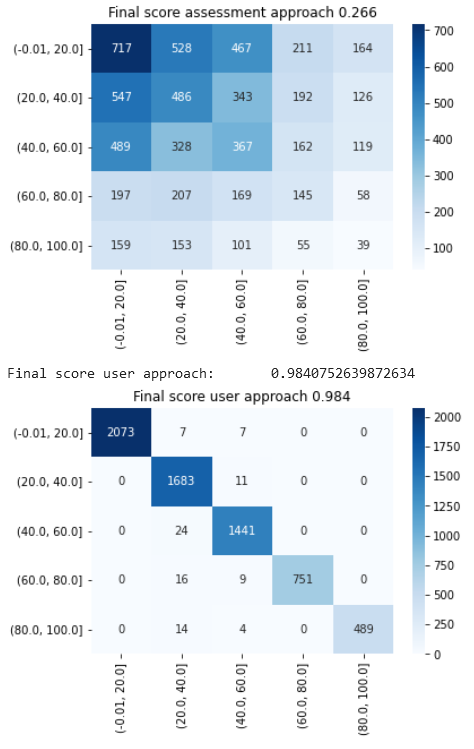

### Take all known assessments

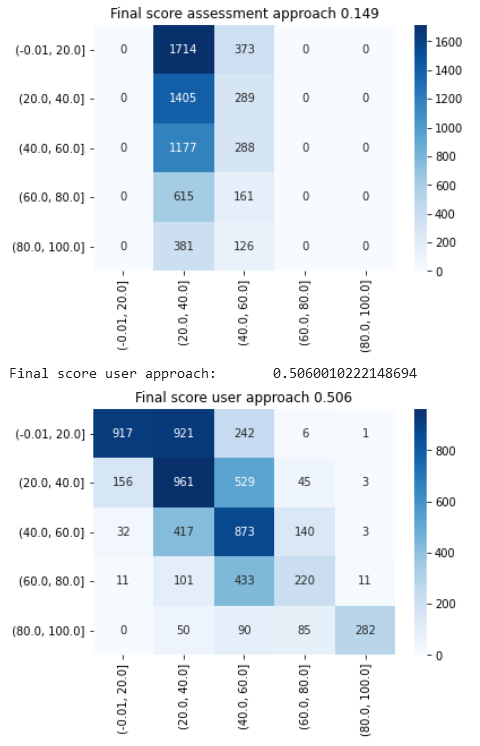

#### Assessment approach
 - `last`: The confusion matrix looks like the model reproduces the distribution of the target of the testset. The performance is worst here.
 - `all`: The more data the model knows, the more it estimates the average class which finally leads to a model only predicts the average class.
 
#### User approach
 - `last`: It looks like the users have a low variance in their reporting behavior. The last known value of this user is the best guess here with almost perfect performance.
 - `all`: This approach is ranked 2nd. Since some user vary their answers during the study, the approach sometimes fails.

## Perform different split approaches to get different model solutions

### Approach | Assessment | Answer-cut

Performance within train
f1_weighted mean  0.5884393749165102
standarddeviation  0.0034182248462100934
f1_weighted testscore:  0.5351539249809311


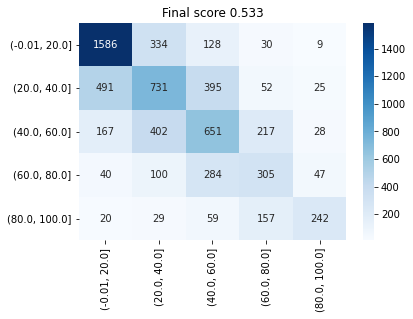

In [7]:
# instantiate model
model = RandomForestClassifier(random_state=1994)

# train model
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1994)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')

# validate model
print('Performance within train')
print('f1_weighted mean ', scores.mean())
print('standarddeviation ', scores.std())

# refit on all training data
model.fit(X_train, y_train)

# evaluate on test set
y_pred = model.predict(X_test)
f1_score_test = f1_score(y_test, y_pred, average='weighted')
final_score = f1_score_test - 0.5 * scores.std()

print('f1_weighted testscore: ', f1_score_test)

# visualize confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cm_array_df = pd.DataFrame(cf_matrix, index=list(mapping.values()), columns=list(mapping.values()))
sns.heatmap(cm_array_df, annot=True, cmap='Blues', fmt='')
plt.title(f'Final score {round(final_score, 3)}')
plt.show()

With the standard random shuffle and ignoring user aspects, the model is better than random guessing. However, without having the information that user groups exist, the score is well below 60 %.

### Approach | Assessment | Time-cut

Performance within train
f1_weighted mean  0.5768925342197493
standarddeviation  0.007905809690969363
f1_weighted testscore:  0.5732424377538043


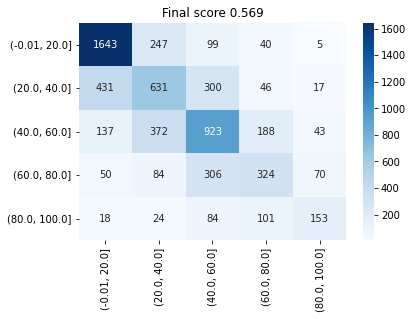

In [77]:
# 80 % of first data into train, 20 % into test
row80 = int(df.shape[0]*0.8)
df_train = df.iloc[:row80, :]
df_test = df.iloc[row80:, :]

# create a group column. Each group belongs to a dategroup. The first 20% of the train data belong to date_group_1, the next 20% belong to date_group_2, and so on.
df_train['group'] = np.sort(np.random.randint(low=1, high=5+1, size = df_train.shape[0]))

# get train and test subsets for X and y
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

# make cumberness a classification instead of regression for the target, not for the feature
y_train = pd.cut(y_train.cumberness_t1, bins=bins)
y_test = pd.cut(y_test.cumberness_t1, bins=bins)

# Label Encode
y_train = LE.transform(y_train)
y_test = LE.transform(y_test)

# instantiate model
model = RandomForestClassifier(random_state=1994)

# define grouped kfold
n_splits = 5
groups = df_train['group'].values
group_kfold = GroupKFold(n_splits=n_splits)

# train model
cv = ShuffleSplit(n_splits=n_splits, test_size=1/n_splits, random_state=1994)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', groups=groups)

# validate model
print('Performance within train')
print('f1_weighted mean ', scores.mean())
print('standarddeviation ', scores.std())

# refit on all training data
model.fit(X_train, y_train)

# evaluate on test set
y_pred = model.predict(X_test)
f1_score_test = f1_score(y_test, y_pred, average='weighted')
final_score = f1_score_test - 0.5 * scores.std()

print('f1_weighted testscore: ', f1_score_test)

# visualize confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cm_array_df = pd.DataFrame(cf_matrix, index=list(mapping.values()), columns=list(mapping.values()))
sns.heatmap(cm_array_df, annot=True, cmap='Blues', fmt='')
plt.title(f'Final score {round(final_score, 3)}')
plt.show()

Making a precise differentiation with evenly sized time chunks, the model improves to the random approach. This might be due to the fact that some users joined the study later, so there was an indirect grouped kfold validation. The score improves from the random approach by 3%-points.

## Evalulate all approaches in one table in terms of performance and robustness